<a href="https://colab.research.google.com/github/asigalov61/Amazon-Deep-Composer/blob/master/Amazon_Deep_Composer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Amazon Deep Composer

## Training a custom AR-CNN model 
In this Jupyter notebook, we guide you through several steps of the data science life cycle. We explain how to acquire the data that you use for this project, 
provide some exploratory data analysis (**EDA**), and show how we augment the data during training. 


### The AWS DeepComposer approach to generating music  
Autoregressive-based approaches are prone to accumulate errors during training. To help mitigate this problem, we train our AR-CNN model so that it can detect and then fix mistakes, including those made by the model itself.

We do this by treating music generation as a series of *edit events*, which can be either the addition or removal of a note. An *edit sequence* is a series of edit events. Every edit sequence can directly correspond to a piano roll.

By training our model to view the problem as edit events rather than as an entire image or just the addition of notes, we found that it can offset the accumulation of errors and generate higher quality music.

Now that you understand the basic theory behind our approach, let’s dive into the code. In the next section, we show examples of the piano roll format that we use for training the model.

#Start Here

## Installing dependencies
First, let's install and import all of the Python packages that we will use in this tutorial.

In [ ]:
#@title Environment and Dependencies Setup. Please be patient as it may take a while. You may also need to run this section twice or trice if there are any errors. And in some cases, Runtime also needs to be restarted
# The MIT-Zero License

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.


# Create the environment and install required packages
!git clone https://github.com/asigalov61/aws-deepcomposer-samples.git
%cd /content/aws-deepcomposer-samples/ar-cnn
%tensorflow_version 1.x
!pip install -r requirements.txt
!pip install tensorflow-gpu==1.15.3
!pip install pyFluidSynth
!apt install fluidsynth
!pip install midi2audio
!pip install utils
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 /content/font.sf2

In [3]:
#@title Import all modules and other necessary code

# Imports

from google.colab import output
from IPython.display import display, Javascript, HTML, Audio
import os
import glob
import json
import numpy as np
import keras
from enum import Enum
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from keras.optimizers import Adam, RMSprop
from keras import backend as K
from random import randrange
import random
import math
import pypianoroll
from utils.midi_utils import play_midi, plot_pianoroll, get_music_metrics, process_pianoroll, process_midi

from augmentation import AddAndRemoveAPercentageOfNotes
from data_generator import PianoRollGenerator
from utils.generate_training_plots import GenerateTrainingPlots
#from inference import Inference
from model import OptimizerType
from model import ArCnnModel
from midi2audio import FluidSynth

class Constants():
    # Make it a multiple of the batch size for best (balanced) performance
    samples_per_ground_truth_data_item = 8
    training_validation_split = 0.9
    # Number of Bars
    bars = 8
    # Number of Beats Per Bar
    beats_per_bar = 4
    beat_resolution = 4
    # number of bars to be shifted
    bars_shifted_per_sample = 8
    # Total number of pitches in a Pianoroll
    number_of_pitches = 128
    # Total number of Tracks
    number_of_channels = 1
    output_file_path = "output_midi.mid"
    tempo = 100  # 100 bpm

!mkdir /content/aws-deepcomposer-samples/ar-cnn/input     

### Download and Unzip Training DataSet


In [ ]:
#@title (The Best Choice/Works best stand-alone) Super Piano Original 2500 MIDIs 
%cd /content/aws-deepcomposer-samples/ar-cnn/input
!wget 'https://github.com/asigalov61/SuperPiano/raw/master/Super_Piano_2_MIDI_DataSet_CC_BY_NC_SA.zip'
!unzip -j 'Super_Piano_2_MIDI_DataSet_CC_BY_NC_SA.zip'

In [ ]:
#@title (Second Best Choice/Works best stand-alone) Alex Piano Only Drafts Original 1500 MIDIs 
%cd /content/aws-deepcomposer-samples/ar-cnn/input
!wget 'https://github.com/asigalov61/AlexMIDIDataSet/raw/master/AlexMIDIDataSet-CC-BY-NC-SA-All-Drafts-Piano-Only.zip'
!unzip -j 'AlexMIDIDataSet-CC-BY-NC-SA-All-Drafts-Piano-Only.zip'

In [ ]:
#!unzip data/JSB\ Chorales.zip -d data
#@title (Alternative Choice) Alex Piano Only Original 450 MIDIs 
!mkdir /content/aws-deepcomposer-samples/ar-cnn/input 
%cd /content/aws-deepcomposer-samples/ar-cnn/input
!wget 'https://github.com/asigalov61/AlexMIDIDataSet/raw/master/AlexMIDIDataSet-CC-BY-NC-SA-Piano-Only.zip'
!unzip -j 'AlexMIDIDataSet-CC-BY-NC-SA-Piano-Only.zip'

# Preprocess and Parse Training DataSet

In [ ]:
#@title Import the MIDI files from the data_dir and save them with the midi_files variable  
data_dir = '/content/aws-deepcomposer-samples/ar-cnn/input/*.*'
midi_files = glob.glob(data_dir)

#Finds our random MIDI file from the midi_files variable and then plays it
#Note: To listen to multiple samples from the Bach dataset, you can run this cell over and over again. 
random_midi = randrange(len(midi_files))
play_midi(midi_files[random_midi])
print(midi_files)
print(midi_files[random_midi])

## Preprocessing the data into the *piano roll* format

### Reviewing sample piano rolls 

### Why do we use 128 timesteps?
In this tutorial, we use 8-[bar](https://en.wikipedia.org/wiki/Bar_(music)) samples from the dataset. We subdivide those 8 bars into 128 timesteps. That's because each of the 8 bars contains 4 beats. We further divide each beat into 4 timesteps. 

This yields 128 timesteps:

$$ \frac{4\;timesteps}{1\;beat} * \frac{4\;beats}{1\;bar} * \frac{8\;bars}{1} = 128\;timesteps $$

We found that this level of resolution is sufficient to capture the musical details in our dataset.

### Creating samples of uniform size (shape) for model training 

For model training, the *input piano rolls* must be the same size. As you saw when we used the `play_midi` function, each sample isn't the same length. We use two functions to create *target piano rolls* that are the same size: `process_midi` and `process_pianoroll`. These functions are wrapped in a larger function, `generate_samples`, which also takes in constants that are related to subdividing the .mid files.

#### In the code cells below:
- `generate_samples` is a function used to ingest the midi files and break the files down into a uniform shape
- `plot_pianoroll` uses a built in function `plot_track` from the  [`pypianoroll`](https://salu133445.github.io/pypianoroll/visualization.html) library to plot a piano roll track from the dataset.

midi file: /content/aws-deepcomposer-samples/ar-cnn/input/Super_Piano_2_MIDI_DataSet_CC_BY_NC_SA.zip is invalid. Ignoring during preprocessing


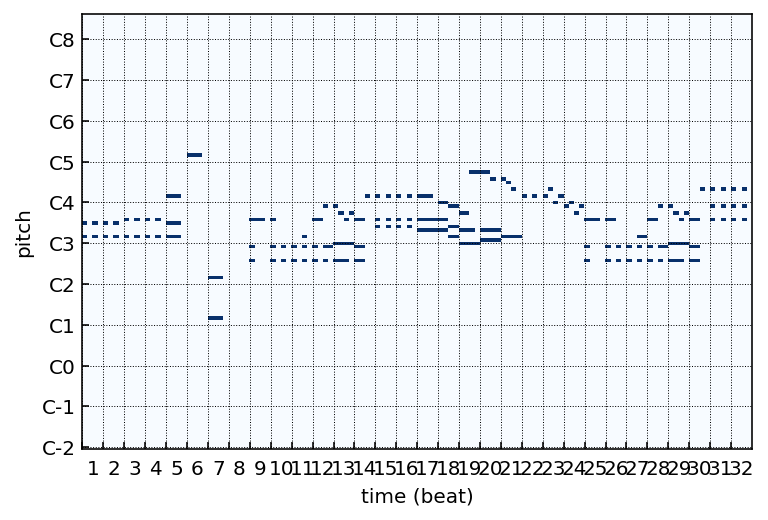

In [6]:
#@title Generate MIDI file samples and shuffle the DataSet
def generate_samples(midi_files, bars, beats_per_bar, beat_resolution, bars_shifted_per_sample):
    """
    dataset_files: All files in the dataset
    return: piano roll samples sized to X bars
    """
    timesteps_per_nbars = bars * beats_per_bar * beat_resolution
    time_steps_shifted_per_sample = bars_shifted_per_sample * beats_per_bar * beat_resolution
    samples = []
    for midi_file in midi_files:
        pianoroll = process_midi(midi_file, beat_resolution) # Parse the MIDI file and get the piano roll
        samples.extend(process_pianoroll(pianoroll, time_steps_shifted_per_sample, timesteps_per_nbars))
    return samples

# Saving the generated samples into a dataset variable 
dataset_samples = generate_samples(midi_files, Constants.bars, Constants.beats_per_bar,Constants.beat_resolution, Constants.bars_shifted_per_sample)
# Shuffle the dataset
random.shuffle(dataset_samples);
random_pianoroll = dataset_samples[randrange(len(dataset_samples))]

plot_pianoroll(random_pianoroll, 4)

### Augment the data for better results and training

We are going to do the following things in this section:

1) Adding or removing notes during training

2) Removing random notes from a target piano roll to create input piano rolls

3) Adding random notes to the target piano roll to create input piano rolls 


In [7]:
#@title Sampling from a uniform distribution
sampling_lower_bound_remove = 0 
sampling_upper_bound_remove = 100
sampling_lower_bound_add = 1
sampling_upper_bound_add = 1.5

#Create, Setup the Model. Setup all (Hyper)Parameters

In [8]:
#@title Calculate Training and Validation sampling lengths
dataset_size = len(dataset_samples)
dataset_split = math.floor(dataset_size * Constants.training_validation_split) 

training_samples = dataset_samples[0:dataset_split]
print("training samples length: {}".format(len(training_samples)))
validation_samples = dataset_samples[dataset_split + 1:dataset_size]
print("validation samples length: {}".format(len(validation_samples)))

training samples length: 14307
validation samples length: 1589


In [9]:
#@title Specifying training hyperparameters. NOTE If you want to test that your model is training on your custom dataset, you can decrease the number of epochs down to 1 in this cell.

# Piano Roll Input Dimensions
input_dim = (Constants.bars * Constants.beats_per_bar * Constants.beat_resolution, 
             Constants.number_of_pitches, 
             Constants.number_of_channels)
# Number of Filters In The Convolution
num_filters = 32
# Growth Rate Of Number Of Filters At Each Convolution
growth_factor = 2
# Number Of Encoder And Decoder Layers
num_layers = 5
# A List Of Dropout Values At Each Encoder Layer
dropout_rate_encoder = [0, 0.5, 0.5, 0.5, 0.5]
# A List Of Dropout Values At Each Decoder Layer
dropout_rate_decoder = [0.5, 0.5, 0.5, 0.5, 0]
# A List Of Flags To Ensure If batch_normalization Should be performed At Each Encoder
batch_norm_encoder = [True, True, True, True, False]
# A List Of Flags To Ensure If batch_normalization Should be performed At Each Decoder
batch_norm_decoder = [True, True, True, True, False]
# Path to Pretrained Model If You Want To Initialize Weights Of The Network With The Pretrained Model
pre_trained = False
# Learning Rate Of The Model
learning_rate = 0.001
# Optimizer To Use While Training The Model
optimizer_enum = OptimizerType.ADAM
# Batch Size
batch_size = 128
# Number Of Epochs
epochs = 3

In [10]:
#@title Calculate the number of Batch Iterations Before A Training Epoch Is Considered Finished
steps_per_epoch = int(
    len(training_samples) * Constants.samples_per_ground_truth_data_item / int(batch_size))

print("The Total Number Of Steps Per Epoch Are: "+ str(steps_per_epoch))

# Total Number Of Time Steps
n_timesteps = Constants.bars * Constants.beat_resolution * Constants.beats_per_bar

The Total Number Of Steps Per Epoch Are: 894


In [11]:
#@title Creating the data generators that perform data augmentation. To create the input piano rolls during training, we need data generators for both the training and validation samples. For our purposes, we use a custom data generator to perform data augmentation.
# Training Data Generator
training_data_generator = PianoRollGenerator(sample_list=training_samples,
                                             sampling_lower_bound_remove = sampling_lower_bound_remove,
                                             sampling_upper_bound_remove = sampling_upper_bound_remove,
                                             sampling_lower_bound_add = sampling_lower_bound_add,
                                             sampling_upper_bound_add = sampling_upper_bound_add,
                                             batch_size = batch_size,
                                             bars = Constants.bars,
                                             samples_per_data_item = Constants.samples_per_ground_truth_data_item,
                                             beat_resolution = Constants.beat_resolution,
                                             beats_per_bar = Constants.beats_per_bar,
                                             number_of_pitches = Constants.number_of_pitches,
                                             number_of_channels = Constants.number_of_channels)
# Validation Data Generator
validation_data_generator = PianoRollGenerator(sample_list = validation_samples,
                                               sampling_lower_bound_remove = sampling_lower_bound_remove,
                                               sampling_upper_bound_remove = sampling_upper_bound_remove,
                                               sampling_lower_bound_add = sampling_lower_bound_add,
                                               sampling_upper_bound_add = sampling_upper_bound_add,
                                               batch_size = batch_size, 
                                               bars = Constants.bars,
                                               samples_per_data_item = Constants.samples_per_ground_truth_data_item,
                                               beat_resolution = Constants.beat_resolution,
                                               beats_per_bar = Constants.beats_per_bar, 
                                               number_of_pitches = Constants.number_of_pitches,
                                               number_of_channels = Constants.number_of_channels)

In [12]:
#@title Creating callbacks for the model and performing initial intitialization
# Callback For Loss Plots 
plot_losses = GenerateTrainingPlots()
## Checkpoint Path
checkpoint_filepath =  '/content/aws-deepcomposer-samples/ar-cnn/trained-model-checkpoint.h5'

# Callback For Saving Model Checkpoints 
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
logdir = "/content/aws-deepcomposer-samples/ar-cnn"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
# Create A List Of Callbacks
callbacks_list = [plot_losses, model_checkpoint_callback, tensorboard_callback]


# Create A Model Instance
MusicModel = ArCnnModel(input_dim = input_dim,
                        num_filters = num_filters,
                        growth_factor = growth_factor,
                        num_layers = num_layers,
                        dropout_rate_encoder = dropout_rate_encoder,
                        dropout_rate_decoder = dropout_rate_decoder,
                        batch_norm_encoder = batch_norm_encoder,
                        batch_norm_decoder = batch_norm_decoder,
                        pre_trained = pre_trained,
                        learning_rate = learning_rate,
                        optimizer_enum = optimizer_enum)

model = MusicModel.build_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 64, 64, 32)   0           conv2d_2[0][0]                   
__________

In [ ]:
#@title Tensorboard Graphs and Stats
# Load the TensorBoard notebook extension
%reload_ext tensorboard
import tensorflow as tf
import datetime, os
%tensorboard --logdir '/content/aws-deepcomposer-samples/ar-cnn'

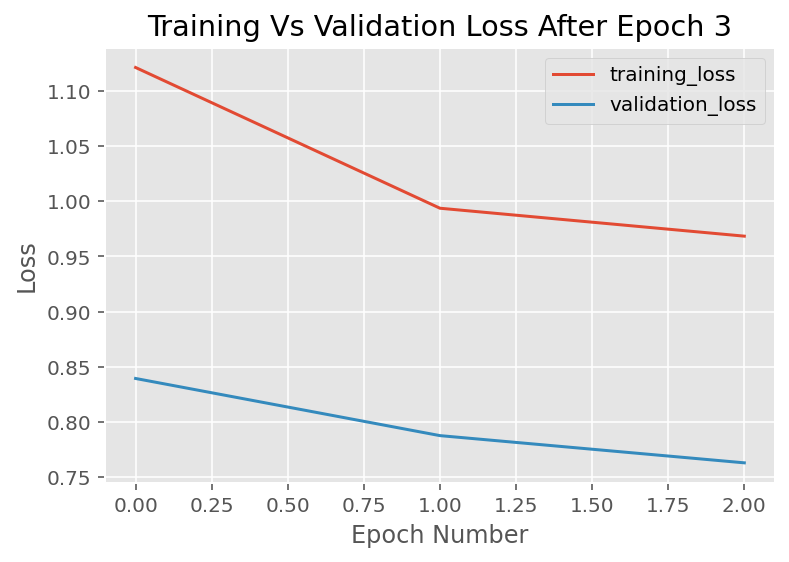

In [14]:
#@title Main Training Loop. In the following cell, you start training your model. NOTE: Training times can vary greatly based on the parameters that you have chosen and the notebook instance type that you chose when launching this notebook.
# Start Training
#logdir = "/content/aws-deepcomposer-samples/ar-cnn"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
history = model.fit_generator(training_data_generator,
                              use_multiprocessing = True,
                              validation_data = validation_data_generator,
                              steps_per_epoch = steps_per_epoch,
                              epochs = epochs,
                              callbacks = callbacks_list) #callbacks_list
model.save('/content/aws-deepcomposer-samples/ar-cnn/trained-model-checkpoint.h5') 

In [ ]:
#@title (Optional) Save your model manually if necessary
model.save('/content/aws-deepcomposer-samples/ar-cnn/trained-model-checkpoint.h5') 

#Generate and Evaluate/Plot from the resulting model

## Performing inference 

Congratulations! You have now trained your very own AR-CNN model to generate music. Now you can see how well your model will perform with an input melody. 


### How to change the *inference parameters* when you perform inference 

The model performs inference by sampling from its predicted probability distribution across the entire piano roll. 

Inference is an iterative process. After adding or removing a note from the input, the model feeds this new input back into itself. The model has been trained to both remove and add notes, so it can improve the input melody and correct mistakes that it may have made in earlier iterations.

You also can change the *inference parameters* to observe differences in the quality of the music generated: 

- Sampling iterations (`samplingIterations`): The number of iterations performed during inference. A higher number of sampling iterations gives the model more time to improve the input melody.

- Maximum notes to remove (`maxPercentageOfInitialNotesRemoved`): The maximum percentage of notes that can be removed during inference. Setting this value to 0% prevents the model from removing notes from your input melody.

- Maximum notes to add (`maxNotesAdded`): The maximum percentage of notes that can be added during inference. Setting this value to 0% means no notes will be added to your input melody

>**NOTE:** If you restrict your model's ability to add and remove notes, you risk creating poor compositions. 

- Creativity, `temperature`: To create the output probability distribution, the final layer uses a softmax activation. You can change the temperature for the softmax to produce different levels of creativity in the outputs generated by the model.


In [21]:
#@title Inference Code Initialization Routine
import os
import logging
import pypianoroll
import keras
import numpy as np
from losses import Loss
import copy

logger = logging.getLogger(__name__)


class Inference:
    def __init__(self, model=None):
        self.model = model
        self.number_of_timesteps = (Constants.beat_resolution *
                                    Constants.beats_per_bar * Constants.bars)

    def load_model(self, model_path):
        """
        Loads a trained keras model
        Parameters
        ----------
        model_path : string
            Full file path to the trained model
        Returns
        -------
        None
        """
        self.model = keras.models.load_model(model_path,
                                             custom_objects={
                                                 'built_in_softmax_kl_loss':
                                                 Loss.built_in_softmax_kl_loss
                                             },
                                             compile=False)

    @staticmethod
    def convert_tensor_to_midi(tensor, tempo, output_file_path):
        """
        Writes a pianoroll tensor to a midi file
        Parameters
        ----------
        tensor : 2d numpy array
            pianoroll to be converted to a midi
        tempo : float
            tempo to output
        output_file_path : str
            output midi file path
        Returns
        -------
        None
        """

        single_track = pypianoroll.Track(pianoroll=tensor)
        multi_track = pypianoroll.Multitrack(
            tracks=[single_track],
            tempo=tempo,
            beat_resolution=Constants.beat_resolution)
        output_file_index = 0
        while os.path.isfile(output_file_path.format(output_file_index)):
            output_file_index += 1
        multi_track.write(output_file_path.format(output_file_index))

    @staticmethod
    def get_indices(input_tensor, value):
        """
        Parameters
        ----------
        input_tensor : 2d numpy array
        value : int (either 1 or 0)
        Returns
        -------
        indices_with_value : 2d array of indices in the input_tensor where the pixel value equals value (1 or 0).
        """
        indices_with_value = np.argwhere(input_tensor.astype(np.bool_) == value)
        return set(map(tuple, indices_with_value))

    @staticmethod
    def get_softmax(input_tensor, temperature):
        """
        Gets the softmax of a tensor with temperature
        Parameters
        ----------
        input_tensor : numpy array
            original tensor (e.g. original predictions)
        temperature : int
            softmax temperature
        Returns
        -------
        tensor : numpy array
            softmax of input tensor with temperature
        """
        tensor = input_tensor / temperature
        tensor = np.exp(tensor)
        tensor = tensor / np.sum(tensor)
        return tensor

    @staticmethod
    def get_sampled_index(input_tensor):
        """
        Gets a randomly chosen index from the input tensor
        Parameters
        ----------
        input_tensor : numpy array
            original tensor
        Returns
        -------
        tensor : numpy array
            softmax of input tensor with temperature
        """

        sampled_index = np.random.choice(range(input_tensor.size),
                                         1,
                                         p=input_tensor.ravel())
        sampled_index = np.unravel_index(sampled_index, input_tensor.shape)
        return sampled_index

    def generate_composition(self, input_midi_path, inference_params):
        """
        Generates a new composition based on an old midi
        Parameters
        ----------
        input_midi_path : str
            input midi path
        inference_params : json
            JSON with inference parameters
        Returns
        -------
        None
        """
        try:
            input_tensor = self.convert_midi_to_tensor(input_midi_path)
            output_tensor = self.sample_multiple(
                input_tensor, inference_params['temperature'],
                inference_params['maxPercentageOfInitialNotesRemoved'],
                inference_params['maxNotesAdded'],
                inference_params['samplingIterations'])
            self.convert_tensor_to_midi(output_tensor, Constants.tempo,
                                        Constants.output_file_path)
        except Exception:
            logger.error("Unable to generate composition.")
            raise

    def convert_midi_to_tensor(self, input_midi_path):
        """
        Converts a midi to pianoroll tensor
        Parameters
        ----------
        input_midi_path : string
            Full file path to the input midi
        Returns
        -------
        2d numpy array
            2d tensor that is a pianoroll
        """

        multi_track = pypianoroll.Multitrack(
            beat_resolution=Constants.beat_resolution)
        try:
            multi_track.parse_midi(input_midi_path,
                                   algorithm='custom',
                                   first_beat_time=0)
        except Exception as e:
            logger.error("Failed to parse the MIDI file.")

        if len(multi_track.tracks) > 1:
            logger.error("Input MIDI file has more than 1 track.")

        multi_track.pad_to_multiple(self.number_of_timesteps)
        multi_track.binarize()
        pianoroll = multi_track.tracks[0].pianoroll

        if pianoroll.shape[0] > self.number_of_timesteps:
            logger.error("Input MIDI file is longer than 8 bars.")

        # truncate
        tensor = pianoroll[0:self.number_of_timesteps, ]
        tensor = np.expand_dims(tensor, axis=0)
        tensor = np.expand_dims(tensor, axis=3)

        return tensor

    def mask_not_allowed_notes(self, current_input_indices, output_tensor):
        """
        Masks notes in output tensor that cannot be added or removed
        Parameters
        ----------
        current_input_indices : 2d numpy array
          indices to be masked based on the current input that was fed to model
        output_tensor : 2d numpy array
          consists of probabilities that are predicted by the model
        Returns
        -------
        2d numpy array - output tensor with not allowed notes masked
        """

        if len(current_input_indices) != 0:
            output_tensor[tuple(np.asarray(list(current_input_indices)).T)] = 0
            if np.count_nonzero(output_tensor) != 0:
                output_tensor = output_tensor / np.sum(output_tensor)
        return output_tensor

    def sample_multiple(self, input_tensor, temperature,
                        max_removal_percentage, max_notes_to_add,
                        number_of_iterations):
        """
        Samples multiple times from an tensor.
        Returns the final output tensor after X number of iterations.
        Parameters
        ----------
        input_tensor : 2d numpy array
            original tensor (i.e. user input melody)
        temperature : float
            temperature to apply before softmax during inference
        max_removal_percentage : float
            maximum percentage of notes that can be removed from the original input
        max_notes_to_add : int
            maximum number of notes that can be added to the original input
        number_of_iterations : int
            number of iterations to sample from the model predictions
        Returns
        -------
        2d numpy array
            output tensor (i.e. new composition)
        """

        max_original_notes_to_remove = int(
            max_removal_percentage * np.count_nonzero(input_tensor) / 100)
        notes_removed_count = 0
        notes_added_count = 0

        original_input_one_indices = self.get_indices(input_tensor, 1)
        original_input_zero_indices = self.get_indices(input_tensor, 0)

        current_input_one_indices = copy.deepcopy(original_input_one_indices)
        current_input_zero_indices = copy.deepcopy(original_input_zero_indices)

        for _ in range(number_of_iterations):
            input_tensor, notes_removed_count, notes_added_count = self.sample_notes_from_model(
                input_tensor, max_original_notes_to_remove, max_notes_to_add,
                temperature, notes_removed_count, notes_added_count,
                original_input_one_indices, original_input_zero_indices,
                current_input_zero_indices, current_input_one_indices)

        return input_tensor.reshape(self.number_of_timesteps,
                                    Constants.number_of_pitches)

    def sample_notes_from_model(self,
                                input_tensor,
                                max_original_notes_to_remove,
                                max_notes_to_add,
                                temperature,
                                notes_removed_count,
                                notes_added_count,
                                original_input_one_indices,
                                original_input_zero_indices,
                                current_input_zero_indices,
                                current_input_one_indices,
                                num_notes=1):
        """
        Generates a sample from the tensor and return a new tensor
        Modifies current_input_zero_indices, current_input_one_indices, and input_tensor
        Parameters
        ----------
        input_tensor : 2d numpy array
            input tensor to feed into the model
        max_original_notes_to_remove : int
            maximum number of notes to remove from the original input
        max_notes_to_add : int
            maximum number of notes that can be added to the original input
        temperature : float
            temperature to apply before softmax during inference
        notes_removed_count : int
            number of original notes that have been removed from input
        notes_added_count : int
            number of new notes that have been added to the input
        original_input_one_indices : set of tuples
            indices which have value 1 in original input
        original_input_zero_indices : set of tuples
            indices which have value 0 in original input
        current_input_zero_indices : set of tuples
            indices which have value 0 and were not part of the original input
        current_input_one_indices : set of tuples
            indices which have value 1 and were part of the original input
        Returns
        -------
        input_tensor : 2d numpy array
            output after samping from the model prediction
        notes_removed_count : int
            updated number of original notes removed
        notes_added_count : int
            updated number of new notes added
        """

        output_tensor = self.model.predict([input_tensor])

        # Apply temperature and softmax
        output_tensor = self.get_softmax(output_tensor, temperature)

        if notes_removed_count >= max_original_notes_to_remove:
            # Mask all pixels that both have a note and were once part of the original input
            output_tensor = self.mask_not_allowed_notes(current_input_one_indices, output_tensor)

        if notes_added_count > max_notes_to_add:
            # Mask all pixels that both do not have a note and were not once part of the original input
            output_tensor = self.mask_not_allowed_notes(current_input_zero_indices, output_tensor)

        if np.count_nonzero(output_tensor) == 0:
            return input_tensor, notes_removed_count, notes_added_count

        sampled_index = self.get_sampled_index(output_tensor)
        sampled_index_transpose = tuple(np.array(sampled_index).T[0])

        if input_tensor[sampled_index]:
            # Check if the note being removed is from the original input
            if notes_removed_count < max_original_notes_to_remove and (
                sampled_index_transpose in original_input_one_indices):
                notes_removed_count += 1
                current_input_one_indices.remove(sampled_index_transpose)
            elif tuple(sampled_index_transpose) not in original_input_one_indices:
                notes_added_count -= 1
                current_input_zero_indices.add(sampled_index_transpose)
            input_tensor[sampled_index] = 0
        else:
            # Check if the note being added is not in original input
            if sampled_index_transpose not in original_input_one_indices:
                notes_added_count += 1
                current_input_zero_indices.remove(sampled_index_transpose)
            else:
                notes_removed_count -= 1
                current_input_one_indices.add(sampled_index_transpose)
            input_tensor[sampled_index] = 1
        input_tensor = input_tensor.astype(np.bool_)
        return input_tensor, notes_removed_count, notes_added_count


In [45]:
#@title MODEL INFERENCE/GENERATION CONTROLS { run: "auto" }
model_temperature = 3 #@param {type:"slider", min:0.1, max:6, step:0.1}
percentage_of_max_removed_notes = 0 #@param {type:"slider", min:0, max:100, step:1}
percentage_of_max_added_notes = 100 #@param {type:"slider", min:0, max:100, step:1}
output_refinement_iterations = 100 #@param {type:"slider", min:0, max:100, step:1}
#with open('inference_parameters.json') as json_file:
#    inference_params = json.load(json_file)
#print(inference_params)

import json

data = {
  u"temperature": float(model_temperature),
  u"maxNotesAdded": int(percentage_of_max_added_notes),
  u"maxPercentageOfInitialNotesRemoved": int(percentage_of_max_removed_notes),
  u"samplingIterations": int(output_refinement_iterations)
}

data = json.dumps(data) # dict to string
inference_params = json.loads(data) # string to json
#print (inference_params)

In [23]:
#@title Loading a saved checkpoint file. To use your trained model, you will need to update the PATH variable in the cell below.
full_path_to_checkpoint_file = "/content/aws-deepcomposer-samples/ar-cnn/trained-model-checkpoint.h5" #@param {type:"string"}

%cd /content/aws-deepcomposer-samples/ar-cnn
# Create An Inference Object
inference_obj = Inference()
# Load The Checkpoint
checkpoint_var = full_path_to_checkpoint_file
inference_obj.load_model(checkpoint_var)

/content/aws-deepcomposer-samples/ar-cnn


###GENERATE AND LISTEN TO THE COMPOSITION

In [40]:
#@title Main Generation Loop
desired_midi_file_full_path = "/content/aws-deepcomposer-samples/ar-cnn/seed.mid" #@param {type:"string"}
# Generate The Composition
%cd /content/aws-deepcomposer-samples/ar-cnn
!rm output_wav.wav output_midi.mid
input_melody = '/content/aws-deepcomposer-samples/ar-cnn/sample_inputs/ode_to_joy.midi'  
inference_obj.generate_composition(desired_midi_file_full_path, inference_params)
FluidSynth("/content/font.sf2").midi_to_audio('output_midi.mid','output_wav.wav')
# set the src and play
Audio("output_wav.wav")

/content/aws-deepcomposer-samples/ar-cnn


<Figure size 1296x432 with 0 Axes>

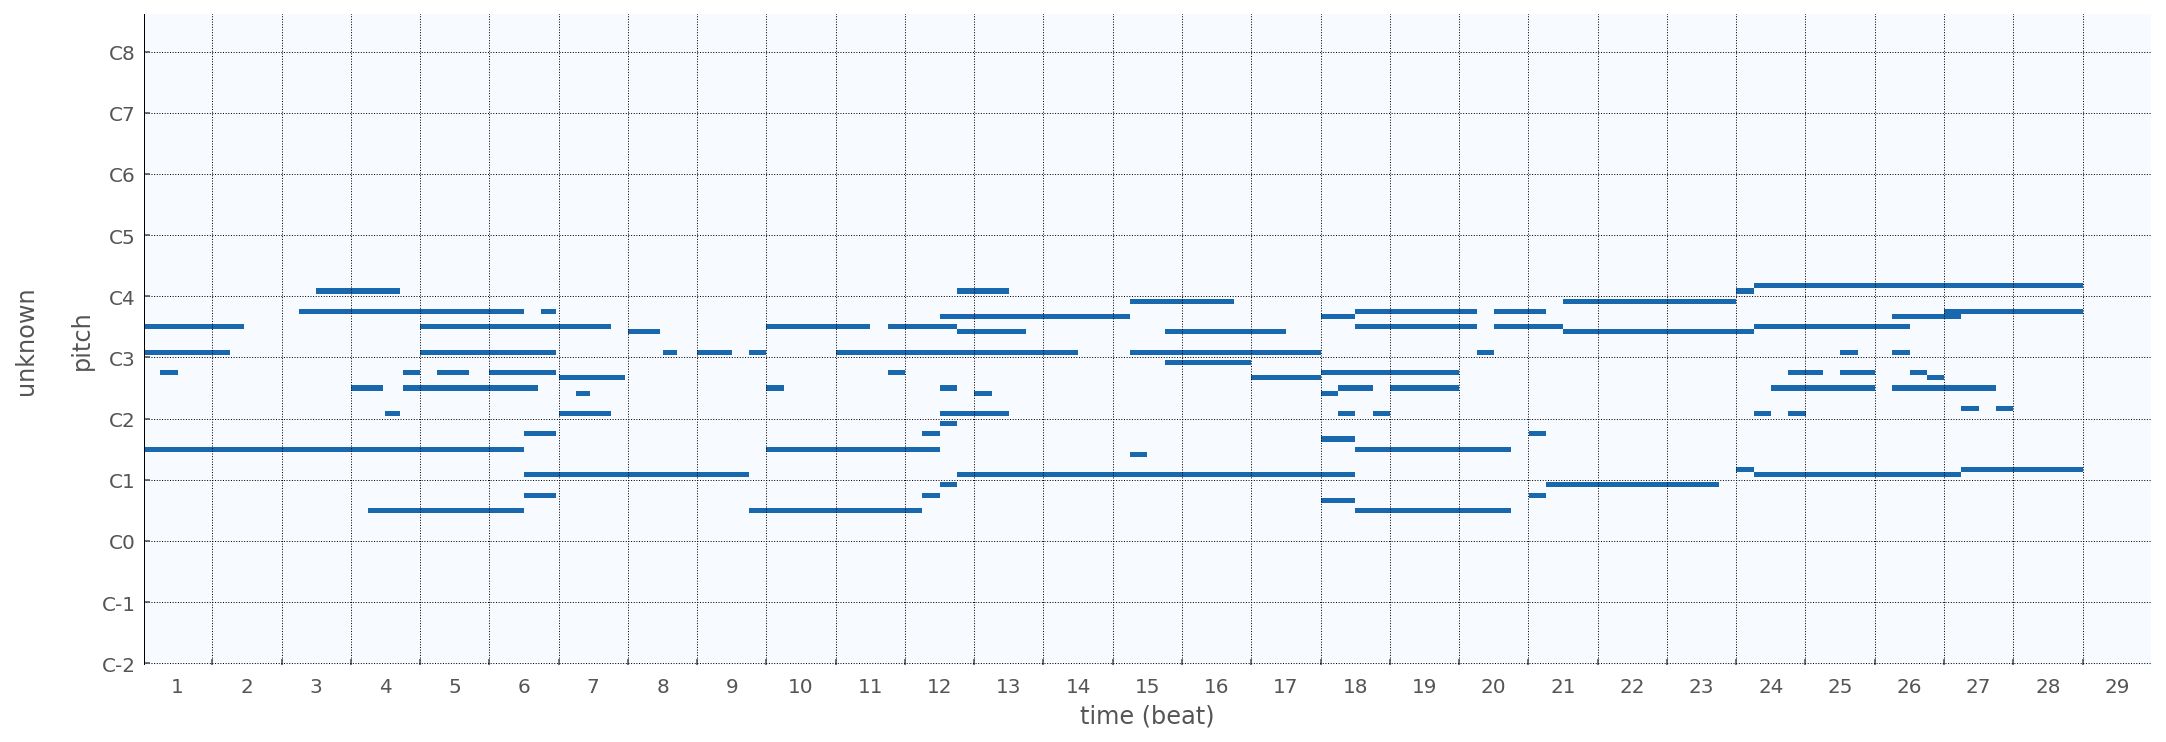

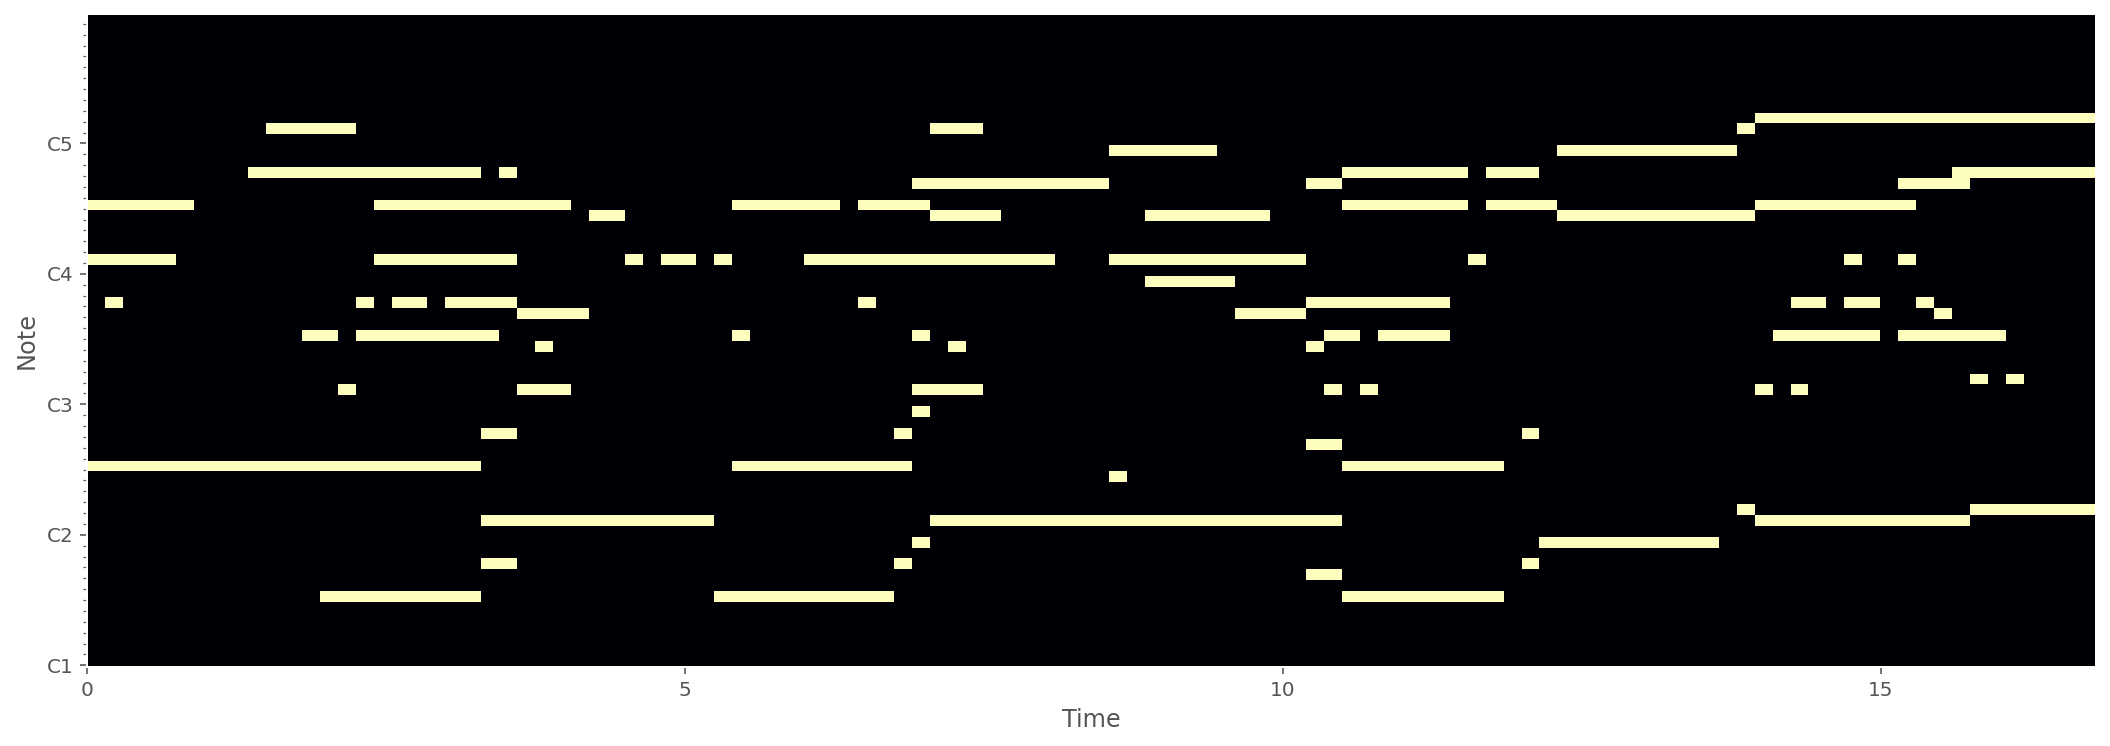

In [41]:
#@title Plot and Graph the Output :) Only first batch MIDI file is plotted and displayed 
graphs_length_inches = 18 #@param {type:"slider", min:0, max:20, step:1}
notes_graph_height = 6 #@param {type:"slider", min:0, max:20, step:1}
rendered_wav_graph_height = 3 #@param {type:"slider", min:0, max:20, step:1}
import librosa
import numpy as np
import pretty_midi
import pypianoroll
from pypianoroll import Multitrack, Track
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('SVG')
# For plotting
import mir_eval.display
import librosa.display
%matplotlib inline
output_melody = '/content/aws-deepcomposer-samples/ar-cnn/output_midi.mid'

midi_data = pretty_midi.PrettyMIDI('/content/aws-deepcomposer-samples/ar-cnn/output_midi.mid')

def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))



roll = np.zeros([int(graphs_length_inches), 128])
# Plot the output

track = Multitrack('/content/aws-deepcomposer-samples/ar-cnn/output_midi.mid', name='track')
plt.figure(figsize=[graphs_length_inches, notes_graph_height])
fig, ax = track.plot()
fig.set_size_inches(graphs_length_inches, notes_graph_height)
plt.figure(figsize=[graphs_length_inches, notes_graph_height])
ax2 = plot_piano_roll(midi_data, 24, 84)
plt.show(block=False)
FluidSynth("/content/font.sf2").midi_to_audio('output_midi.mid','output_wav.wav')
# set the src and play
Audio("output_wav.wav")

The input midi metrics are:
+----------------------+---------------+-----------------+----------------+
| n_pitch_classes_used | in_scale_rate | polyphonic_rate | n_pitches_used |
+======================+===============+=================+================+
| 4                    | 0.570         | 15              | 61.018         |
+----------------------+---------------+-----------------+----------------+


The generated output midi metrics are:
+----------------------+---------------+-----------------+----------------+
| n_pitch_classes_used | in_scale_rate | polyphonic_rate | n_pitches_used |
+======================+===============+=================+================+
| 5                    | 0.792         | 26              | 39.704         |
+----------------------+---------------+-----------------+----------------+


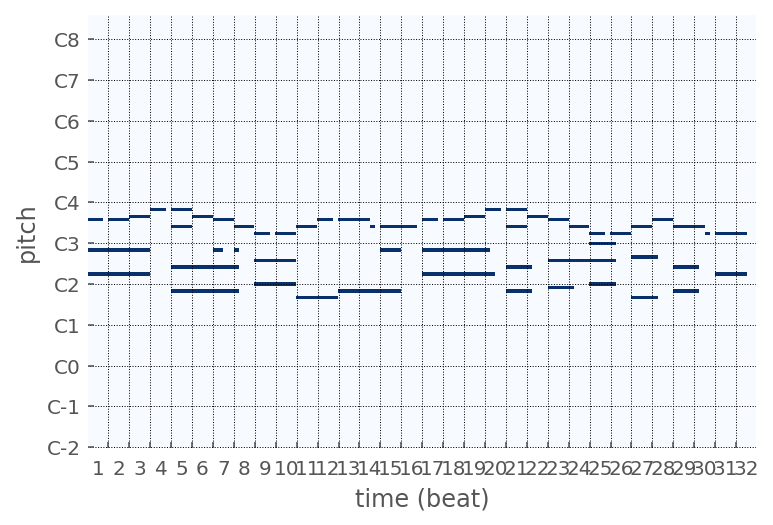

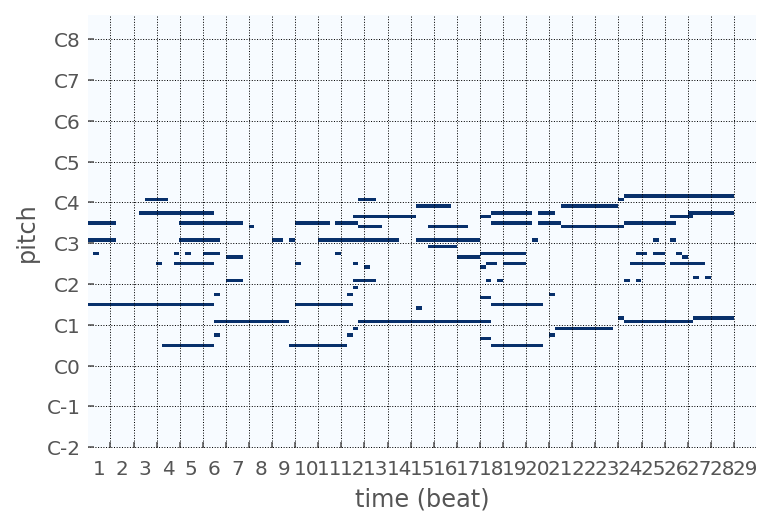

In [42]:
#@title Additional Input/Output Comparison Metrics of the specified MIDI file
# Input Midi Metrics:
print("The input midi metrics are:")
get_music_metrics(input_melody, beat_resolution=4)

print("\n")
# Generated Output Midi Metrics:
print("The generated output midi metrics are:")
get_music_metrics(output_melody, beat_resolution=4)

# Convert The Input and Generated Midi To Tensors (a matrix)
input_pianoroll = process_midi(input_melody, beat_resolution=4)
output_pianoroll = process_midi(output_melody, beat_resolution=4)

# Plot Input Piano Roll
plot_pianoroll(input_pianoroll, beat_resolution=4)

# Plot Output Piano Roll
plot_pianoroll(output_pianoroll, beat_resolution=4)

## Submitting to the *Spin the Model* Chartbusters challnege

To submit your composition(s) and model to the *Spin the model* chartbusters challenge you will first need to create a public repository on [GitHub](https://github.com/). Then download your notebook, checkpoint files, and compositions from SageMaker, and upload them to your public repository. Use the link from your public repository to make your submission to the Chartbusters challenge! 

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
